# Import Libraries

In [1]:
import numpy as np
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')


In [2]:
parasitized_dir = r"..\fyp\cell_images\Parasitized"
uninfected_dir = r"..\fyp\cell_images\Uninfected"

# Data Argumentation

In [3]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_data_gen = ImageDataGenerator() 


# Data Exploration and Pre processing

In [4]:
def load_and_preprocess_images(directory, label, target_size=(128, 128)):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(directory, filename)
            with Image.open(img_path) as img:
                # Resize the image
                img_resized = img.resize(target_size)
                # Convert the image to array
                img_array = img_to_array(img_resized)
                # Normalize pixel values
                img_array /= 255.0
                images.append(img_array)
                labels.append(label)
    return np.array(images), np.array(labels)

## Loading and preprocessing the data

In [5]:
parasitized_images, parasitized_labels = load_and_preprocess_images(parasitized_dir, label=1)
uninfected_images, uninfected_labels = load_and_preprocess_images(uninfected_dir, label=0)

## Count the Number of images in each of the directory

In [6]:
print(f"Number of images from the Parasitized directory: {parasitized_images.shape[0]}")
print(f"Number of images from the Uninfected directory : {uninfected_images.shape[0]}")

Number of images from the Parasitized directory: 13779
Number of images from the Uninfected directory : 13779


## Display Sample Images 

In [7]:
def display_images(parasitized_images, uninfected_images):
    
    parasitized_img = parasitized_images[0]
    uninfected_img = uninfected_images[0]
    
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    
    axes[0].imshow(parasitized_img)
    axes[0].set_title("Parasitized")
    axes[0].axis('off')
    
    axes[1].imshow(uninfected_img)
    axes[1].set_title("Uninfected")
    axes[1].axis('off')
    
    plt.show()


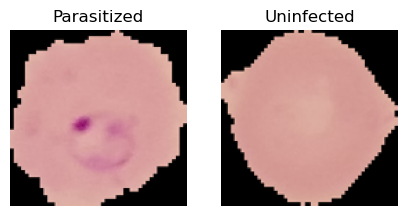

In [8]:
display_images(parasitized_images, uninfected_images)

## Train-Test Split

In [9]:
# Concatenate images and labels
images = np.concatenate((parasitized_images, uninfected_images), axis=0)
labels = np.concatenate((parasitized_labels, uninfected_labels), axis=0)


In [10]:
# Split dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) 

print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_val.shape[0]}')
print(f'Testing set size: {X_test.shape[0]}')

Training set size: 16534
Validation set size: 5512
Testing set size: 5512


In [11]:
# Apply data argumentation to train set
batch_size=128
train_set = data_gen.flow(X_train, y_train, batch_size=batch_size)
val_set = val_data_gen.flow(X_val, y_val,batch_size=batch_size)


# Baseline Model


In [12]:
def random_classifier(X, num_classes=2):
    np.random.seed(42)  
    return np.random.randint(0, num_classes, size=(X.shape[0],))

y_val_pred = random_classifier(X_val, num_classes=len(np.unique(y_train)))

val_accuracy = accuracy_score(y_val, y_val_pred)
# print accuracy
print(f"Validation Accuracy of Random Classifier: {val_accuracy:.2f}")


Validation Accuracy of Random Classifier: 0.50


# CNN Model

In [14]:
def cnn_model(input_shape):
    model = models.Sequential()
    # Convolutional Layer 1
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    # Convolutional Layer 2
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten the layers
    model.add(layers.Flatten())
    
    # Fully Connected Layer  
    model.add(layers.Dense(32, activation='relu'))

    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid')) 
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [15]:
def plot_accuracy(history):
    plt.clf()
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    # Line plot for training accuracy
    plt.plot(epochs, history.history['accuracy'], color='red', label='Training Accuracy')
    # Scatter plot for validation accuracy
    plt.scatter(epochs, history.history['val_accuracy'], color='blue', label='Validation Accuracy')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_loss(history):
    plt.clf()
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Line plot for training loss
    plt.plot(epochs, history.history['loss'], color='red', label='Training Loss')
    # Scatter plot for validation loss
    plt.scatter(epochs, history.history['val_loss'], color='blue', label='Validation Loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()




# Training

In [16]:
input_shape = X_train.shape[1:]
model = cnn_model(input_shape)

# Train the model
history = model.fit(
    train_set,
    epochs=10,
    validation_data=val_set 
)


Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 132s 945ms/step - accuracy: 0.5599 - loss: 0.7356 - val_accuracy: 0.6658 - val_loss: 0.6493
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 125s 926ms/step - accuracy: 0.6446 - loss: 0.6570 - val_accuracy: 0.7259 - val_loss: 0.6246
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 95s 686ms/step - accuracy: 0.6747 - loss: 0.6340 - val_accuracy: 0.8017 - val_loss: 0.5712
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 75s 556ms/step - accuracy: 0.7678 - loss: 0.5846 - val_accuracy: 0.9410 - val_loss: 0.4010
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 69s 512ms/step - accuracy: 0.8302 - loss: 0.5089 - val_accuracy: 0.9351 - val_loss: 0.3850
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 69s 508ms/step - accuracy: 0.8758 - loss: 0.4357 - val_accuracy: 0.9456 - val_loss: 0.3617
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 69s 508ms/step - accuracy: 0.8888 - loss: 0.4234 - val_accuracy: 0.9472 - val_loss: 0.3117
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 65s 471ms/step - accuracy: 0.9063 - loss:

In [17]:
val_loss, val_accuracy = model.evaluate(val_set)

44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9495 - loss: 0.2591


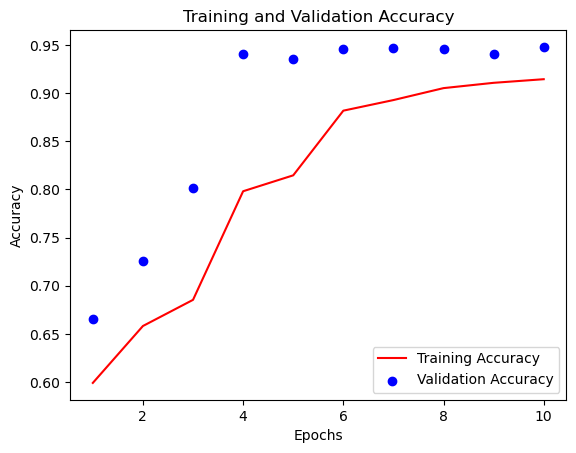

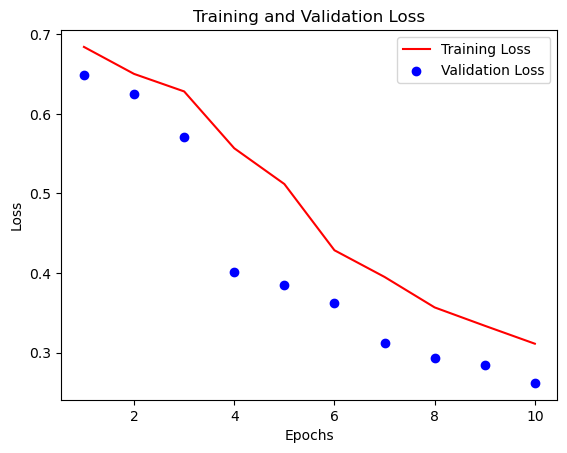

In [18]:
# Plot accuracy and loss graphs
plot_accuracy(history)
plot_loss(history)

 # Hyperparameter tuning

In [19]:
def improved_cnn_model(input_shape):
    model = models.Sequential()
    
    # Convolutional Layer 1
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))
    
    # Convolutional Layer 2
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
   
    # Convolutional Layer 3
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    # Convolutional Layer 4
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    # Flatten the layers
    model.add(layers.Flatten())

   # Fully Connected Layer 
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

   # Drop out layer
    model.add(layers.Dropout(0.5))

    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model

In [20]:
input_shape = X_train.shape[1:]  
model_1 = improved_cnn_model(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_1 = model_1.fit(
    train_set,
    epochs=10,
    validation_data=val_set,
    callbacks=[early_stopping]
)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 81s 586ms/step - accuracy: 0.5595 - loss: 1.0405 - val_accuracy: 0.6923 - val_loss: 0.6068
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 83s 622ms/step - accuracy: 0.8105 - loss: 0.4984 - val_accuracy: 0.9418 - val_loss: 0.2497
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 80s 595ms/step - accuracy: 0.9002 - loss: 0.3478 - val_accuracy: 0.9392 - val_loss: 0.2478
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 79s 588ms/step - accuracy: 0.9002 - loss: 0.3375 - val_accuracy: 0.9530 - val_loss: 0.2249
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 79s 585ms/step - accuracy: 0.9064 - loss: 0.3242 - val_accuracy: 0.9510 - val_loss: 0.2157
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 111s 839ms/step - accuracy: 0.9127 - loss: 0.3044 - val_accuracy: 0.9521 - val_loss: 0.2137
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 89s 666ms/step - accuracy: 0.9142 - loss: 0.3038 - val_accuracy: 0.9519 - val_loss: 0.2205
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 83s 619ms/step - accuracy: 0.9219 - loss: 

In [21]:
val_loss, val_accuracy = model_1.evaluate(val_set)

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9530 - loss: 0.1825


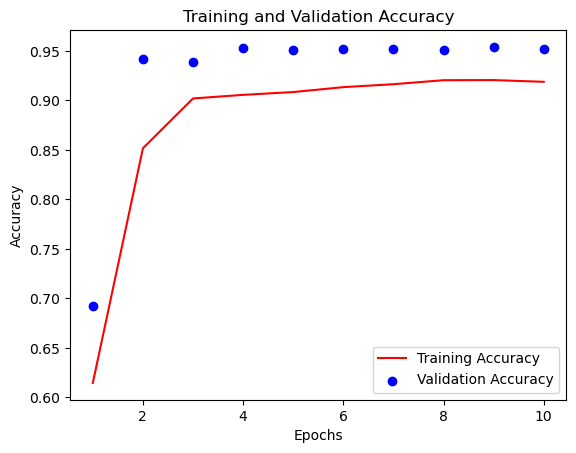

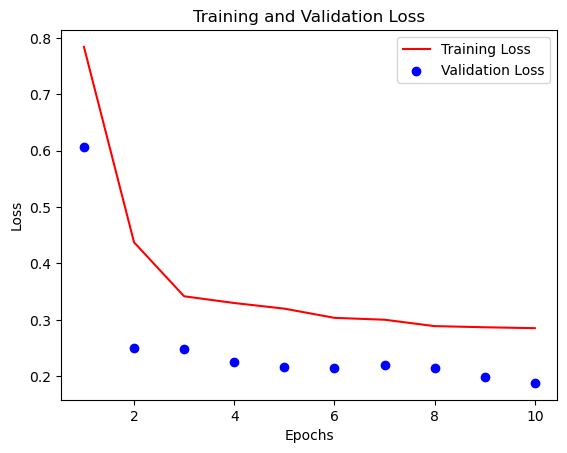

In [22]:
# plot accuracy and loss graphs
plot_accuracy(history_1)
plot_loss(history_1)

# Testing

In [23]:
val_loss, val_accuracy = model_1.evaluate(X_test, y_test)

173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9527 - loss: 0.1890


# Evaluation

In [24]:
# Predict probabilities on the test set
y_pred_test = model_1.predict(X_test)

# Convert probabilities to binary labels 
y_pred_labels_test = (y_pred_test > 0.5).astype(int).flatten()

precision_test = precision_score(y_test, y_pred_labels_test, average='binary')
recall_test = recall_score(y_test, y_pred_labels_test, average='binary')
f1_test = f1_score(y_test, y_pred_labels_test, average='binary')

# Convert to percentage
precision_percentage_test = precision_test * 100
recall_percentage_test = recall_test * 100
f1_percentage_test = f1_test * 100

print("Test Precision : {:.2f}%".format(precision_percentage_test))
print("Test Recall : {:.2f}%".format(recall_percentage_test))
print("Test F1 Score : {:.2f}%".format(f1_percentage_test))


173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step
Test Precision : 97.28%
Test Recall : 93.31%
Test F1 Score : 95.26%
